Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: colorspace

Loading required package: khroma

Loading required package: ggplot2

Loading required package: ggpattern

Loading required package: reshape2

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
✔ readr     2.1.4     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyv

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

[[18]]
[1] TRUE

[[19]]
[1] TRUE

[[20]]
[1] TRUE

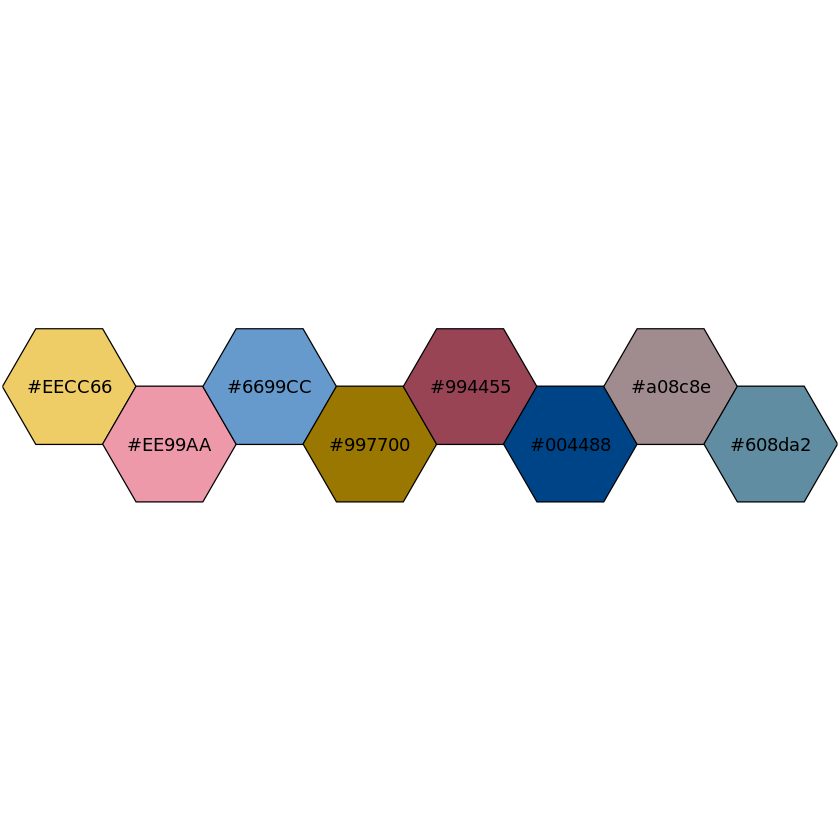

In [2]:
f_func <- "../functions.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_func, '--to=script', '--stdout'), stdout = TRUE)))
f_path <- "../dirs.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_path, '--to=script', '--stdout'), stdout = TRUE)))
f_cols <- "../cols.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_cols, '--to=script', '--stdout'), stdout = TRUE)))

In [3]:
sample_nm <- c()
step_nm <- c()
for (file in list.files(SPL_STATS_DIR, pattern = "R1")){
    sample_nm <- c(sample_nm, unlist(strsplit(file, '_'))[1])
    step_nm <- c(step_nm, paste0(unlist(strsplit(file, '_'))[3], unlist(strsplit(file, '_'))[4]))
}
mt <- matrix(ncol = length(unique(sample_nm)), nrow = length(unique(step_nm)))
colnames(mt) <- unique(sample_nm)
rownames(mt) <- unique(step_nm)
for (file in list.files(SPL_STATS_DIR)){
    sample <- unlist(strsplit(file, '_'))[1]
    step <- paste0(unlist(strsplit(file, '_'))[3], unlist(strsplit(file, '_'))[4])
    line_count <- read.csv(file = paste0(SPL_STATS_DIR,file), header=FALSE, sep = "\t", stringsAsFactors=FALSE)
    mt[step, sample] <- line_count[1,1]
}

In [4]:
cfSPI_steps <- sweep(mt[c(1:2,4),],2,mt[1,],'/') %>% melt(value.name = "line_count", varnames = c("step", "sample")) %>%
    mutate(sample_short = str_replace(sample, str_sub(sample, 1, 3), "")) %>%
    filter(sample_short %in% c("Bctrl", "Pctrl")) %>% 
    mutate(sample_short = ifelse(sample_short == "Bctrl", yes = "BAL fluid, control", no = sample_short))  %>% 
    mutate(sample_short = ifelse(sample_short == "Pctrl", yes = "plasma, control", no = sample_short))  %>% 
    filter(!grepl(sample, pattern = "[A-Z]$")) %>% 
    filter(grepl(sample, pattern = "^H")) %>% 
    filter(sample %nin% c("H02Bctrl", "H23Bctrl")) %>% 
    mutate(line_count = line_count*100) %>% 
    mutate(step_short = str_sub(step, 2, 2)) %>% 
    ggplot(aes(x = step_short, y = line_count, group = sample, color = sample_short)) + 
        geom_line(aes(color = sample_short), linewidth = 1.5, alpha = 0.3) + theme_bw() + 
        theme(plot.title = element_text(hjust = 0.5, face = "bold")) +
        labs(x = "", y = "% reads retained after filtering", color = "") + 
        scale_color_manual(values=alpha(c(as.character(colors_mc[c(5,6)])), 0.6)) + 
        ylim(50,100) + 
        scale_x_discrete(labels=c("1" = "raw data", 
                                  "2" = "unique reads\nafter duplicate removal", 
                                  "3" = "high-quality reads\nafter low-quality and short read removal", 
                                  "4" = "QC reads")) + guides(color = "none")

In [5]:
thrshlds <- mediumcontrast(6)[c(4,1)]
names(thrshlds) <- c(0.0, 0.8)

In [6]:
nm_oi <- list_oi <- c("Archaea", "Bacteria", "Fungi", "Viruses", "Homo sapiens")
mt_t <- matrix(ncol = 6, nrow = length(nm_oi))
colnames(mt_t) <- c("genome", "conf", "sample", "type", "value", "taxa")
rownames(mt_t) <- nm_oi

if(exists("default_df")){rm("default_df")}
for (file in list.files(SPL_K2pb_REP, recursive = TRUE, pattern = ".report")){
    mt_tmp <- mt_t
    gnm <- gsub(file, pattern = "/.*", replacement = "")
    mt_tmp[,"genome"] <- gnm
    smpl <- gsub(gsub(file, pattern = "_conf.*", replacement = ""), pattern = ".*/", replacement = "")
    mt_tmp[,"sample"] <- smpl
    mt_tmp[,"conf"] <- gsub(gsub(gsub(file, pattern = ".report", replacement = ""), 
                                               pattern = ".*_", replacement = ""), 
                                               pattern = "conf", replacement = "")
    
    k2prep <- read.csv(paste0(SPL_K2pb_REP, file), header=FALSE, sep = "\t", stringsAsFactors=FALSE)
    k2prep$V8 <- str_trim(k2prep$V8, side = "left")
    for (i in nm_oi){
        mt_tmp[i,"type"] <- i
        mt_tmp[i,"value"] <- as.numeric(k2prep$V2[which(k2prep$V8 == i)])
    }

    QC_rc <- mt["04adapt", smpl]
    mt_tmp[,"value"] <- as.numeric(mt_tmp[,"value"])/QC_rc*10^6
    
    mt_tmp[,"taxa"] <- rownames(mt_tmp)
    if(!exists("default_df")){default_df <- mt_tmp} else {default_df <- rbind(default_df, mt_tmp)}
}

In [7]:
lines <- data.frame(intercept = as.double(names(thrshlds)), names = paste0("Threshold ", names(thrshlds)))
all_thresholds_suppl <- default_df %>% as.data.frame() %>% 
    filter(taxa %nin% c("Homo sapiens")) %>% 
    mutate(sample_short = str_replace(sample, str_sub(sample, 1, 3), "")) %>%
    filter(sample_short %in% c("Bctrl", "Pctrl")) %>% 
    mutate(sample_short = ifelse(sample_short == "Bctrl", yes = "BAL fluid, control", no = sample_short))  %>% 
    mutate(sample_short = ifelse(sample_short == "Pctrl", yes = "plasma, control", no = sample_short))  %>% 
    filter(!grepl(sample, pattern = "[A-Z]$")) %>% 
    filter(grepl(sample, pattern = "^H")) %>% 
    filter(sample %nin% c("H02Bctrl", "H23Bctrl")) %>% 
    filter(!grepl(step, pattern = "0[1-4]")) %>%     
    mutate(value = as.numeric(value)) %>% 
    mutate(conf = as.numeric(conf)) %>% 
    ggplot(aes(x = conf, y = value, col = sample_short, group = c(sample), shape = taxa)) + 
        geom_line(size = 1.5) + 
        geom_vline(data  = lines, aes(xintercept = intercept, color = names), linetype = 2, size = 1.5) +
        facet_grid(vars(taxa),vars(genome), scales = "free_y") + 
        scale_color_manual(values=alpha(c(as.character(colors_mc[c(5,6)]), "black", "grey"), 0.6)) + 
        theme_bw() +
        scale_x_continuous(breaks=seq(0,1,0.2)) + 
        labs(y = "RPM", x = "Confidence Threshold") + 
        #ggtitle("unmapped reads classified", subtitle = "") + 
        theme_bw() + theme(plot.title = element_text(hjust = 0.5, face = "bold"), strip.background = element_blank()) +
        labs(color = "")

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


In [8]:
k2_prebuild_data <- as.data.frame(default_df) %>% 
    mutate(conf = as.character(conf)) %>%
    mutate(sample_short = str_replace(sample, str_sub(sample, 1, 3), "")) %>%
    filter(sample_short %in% c("Bctrl", "Pctrl")) %>% 
    mutate(sample_short = ifelse(sample_short == "Bctrl", yes = "BAL fluid, control", no = sample_short))  %>% 
    mutate(sample_short = ifelse(sample_short == "Pctrl", yes = "plasma, control", no = sample_short))  %>% 
    filter(!grepl(sample, pattern = "[A-Z]$")) %>% 
    filter(grepl(sample, pattern = "^H")) %>%  
    filter(sample %nin% c("H02Bctrl", "H23Bctrl"))  %>% 
    mutate(value = as.numeric(value)) %>% 
    mutate(genome = ifelse(grepl(genome, pattern = "chm13_grch38"), "GRCh38.p14\n& CHM13v2", 
                    ifelse(grepl(genome, pattern = "grch38"), "GRCh38.p14", 
                    ifelse(grepl(genome, pattern = "chm13"), "CHM13v2", NA))))  %>% 
    mutate(genome = factor(genome, levels = c("GRCh38.p14", "CHM13v2", "GRCh38.p14\n& CHM13v2"))) 

k2_prebuild_norm <- k2_prebuild_data
for (r in 1:nrow(k2_prebuild_norm)){
    devide <- k2_prebuild_norm %>% 
        filter(genome == "GRCh38.p14") %>% 
        filter(conf == k2_prebuild_norm$conf[r]) %>% 
        filter(sample == k2_prebuild_norm$sample[r]) %>% 
        filter(type == k2_prebuild_norm$type[r]) %>% 
        filter(taxa == k2_prebuild_norm$taxa[r]) %>% 
        filter(sample_short == k2_prebuild_norm$sample_short[r]) %>% select(value) 
    k2_prebuild_norm[r,"value"] = k2_prebuild_norm[r,"value"]/devide 
}

In [13]:
stat.test_prebuild <- k2_prebuild_data %>% 
    filter(taxa %nin% c("Fungi", "Homo sapiens")) %>% 
    filter(conf == gsub(fav_threshold, pattern = "conf", replacement = "")) %>% 
    group_by(taxa) %>% 
        t_test(value ~ genome, paired = TRUE, 
            p.adjust.method="bonferroni", 
            var.equal = sample, alternative = "greater")  %>% 
        mutate(p.adj.signif = ifelse(p.adj.signif == "", "#", no = p.adj.signif))

micr_k2_standard <- k2_prebuild_norm %>% 
    filter(taxa %nin% c("Fungi", "Homo sapiens")) %>% 
    filter(conf == gsub(fav_threshold, pattern = "conf", replacement = "")) %>% 
    ggplot(aes(x = genome, y = value)) + 
        geom_dotplot(aes(fill = sample_short), col = NA, width = 0.6, binaxis = "y", stackdir = "center", dotsize = 1.5) + 
        geom_violin(aes(col = genome), width = 0.4, size = 1, fill = NA) + 
        theme_bw() + theme(panel.spacing.y = unit(2, "lines"), 
                            plot.title = element_text(hjust = 0.5, face = "bold"), 
                            strip.background = element_blank()) + 
        labs(x = "", y = "RPM, normalized", fill = "") + 
        stat_pvalue_manual(size = 5, stat.test_prebuild, 
                           label = "p.adj.signif", y.position = c(1.1125,1.15,1.1875)) +
        geom_hline(yintercept = 1.0375) + 
        scale_fill_manual(values=alpha(c(as.character(colors_mc[c(5,6)])), 0.6)) + 
        scale_color_manual(values=alpha(c("black", as.character(colors_mc[c(4,1)])), 0.6)) + 
        facet_grid(rows = vars(taxa)) +
        guides(color = FALSE) + xlab("") +
        scale_y_continuous(breaks = seq(0.5,1.00,0.1), limits = c(0.5,1.1875), labels = seq(0.50,1.00,0.1)) +
        geom_text(size = 5,position = position_dodge(0.5), hjust = 0.5,
            data = k2_prebuild_data %>% 
                  filter(taxa %nin% c("Fungi", "Homo sapiens")) %>% 
                  filter(conf == gsub(fav_threshold, pattern = "conf", replacement = "")) %>% group_by(taxa, genome) %>% 
                  summarise(meanY = c(round(mean(value), digits = 2)), 
                        labY = paste0("mu =", round(mean(value), digits = 2)), .groups = "keep"),
                  aes(x = genome, y = 1.075, label = labY)) 

In [14]:
stat.test_prebuild_0.8 <- k2_prebuild_data %>% 
    filter(taxa %nin% c("Homo sapiens")) %>% 
    filter(conf == "0.8") %>% 
    group_by(taxa) %>% 
        t_test(value ~ genome, paired = TRUE, 
            p.adjust.method="bonferroni", 
            var.equal = sample, alternative = "greater")  %>% 
        mutate(p.adj.signif = ifelse(p.adj.signif == "", "#", no = p.adj.signif))

micr_k2_standard_0.8 <- k2_prebuild_norm %>% 
    filter(taxa %nin% c("Homo sapiens")) %>% 
    filter(conf == "0.8") %>% 
    ggplot(aes(x = genome, y = value)) + 
        geom_dotplot(aes(fill = sample_short), col = NA, width = 0.6, binaxis = "y", stackdir = "center", dotsize = 1.5) + 
        geom_violin(aes(col = genome), width = 0.4, size = 1, fill = NA) + 
        theme_bw() + theme(panel.spacing.y = unit(2, "lines"), 
                            plot.title = element_text(hjust = 0.5, face = "bold"), 
                            strip.background = element_blank()) + 
        labs(x = "", y = "RPM, normalized", fill = "") + 
        stat_pvalue_manual(size = 5, stat.test_prebuild_0.8, 
                           label = "p.adj.signif", y.position = c(c(1.1,1.125,1.15)+0.025)) +
        geom_hline(yintercept = 1.0375) + 
        scale_fill_manual(values=alpha(c(as.character(colors_mc[c(5,6)])), 0.6)) + 
        scale_color_manual(values=alpha(c("black", as.character(colors_mc[c(4,1)])), 0.6)) + 
        facet_grid(rows = vars(taxa)) +
        guides(color = FALSE) + xlab("") +
        scale_y_continuous(breaks = seq(0.9,1.00,0.05), limits = c(0.9,1.1875), labels = seq(0.90,1.00,0.05)) +
        geom_text(size = 5,position = position_dodge(0.5), hjust = 0.5,
            data = k2_prebuild_data %>% 
                   filter(taxa %nin% c("Homo sapiens")) %>% 
                   filter(conf == "0.8") %>% group_by(taxa, genome) %>% 
                  summarise(meanY = c(round(mean(value), digits = 2)), 
                        labY = paste0("mu =", round(mean(value), digits = 2)), .groups = "keep"),
                  aes(x = genome, y = 1.075, label = labY)) 

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.
Warning message:
“Removed 3 rows containing missing values (`stat_bindot()`).”
Warning message:
“Removed 3 rows containing non-finite values (`stat_ydensity()`).”
Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.
Warning message:
“Removed 3 rows containing missing values (`stat_bindot()`).”
Warning message:
“Removed 3 rows containing non-finite values (`stat_ydensity()`).”
Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.
Warning message:
“Removed 3 rows containing missing values (`stat_bindot()`).”
Warning message:
“Removed 3 rows containing non-finite values (`sta

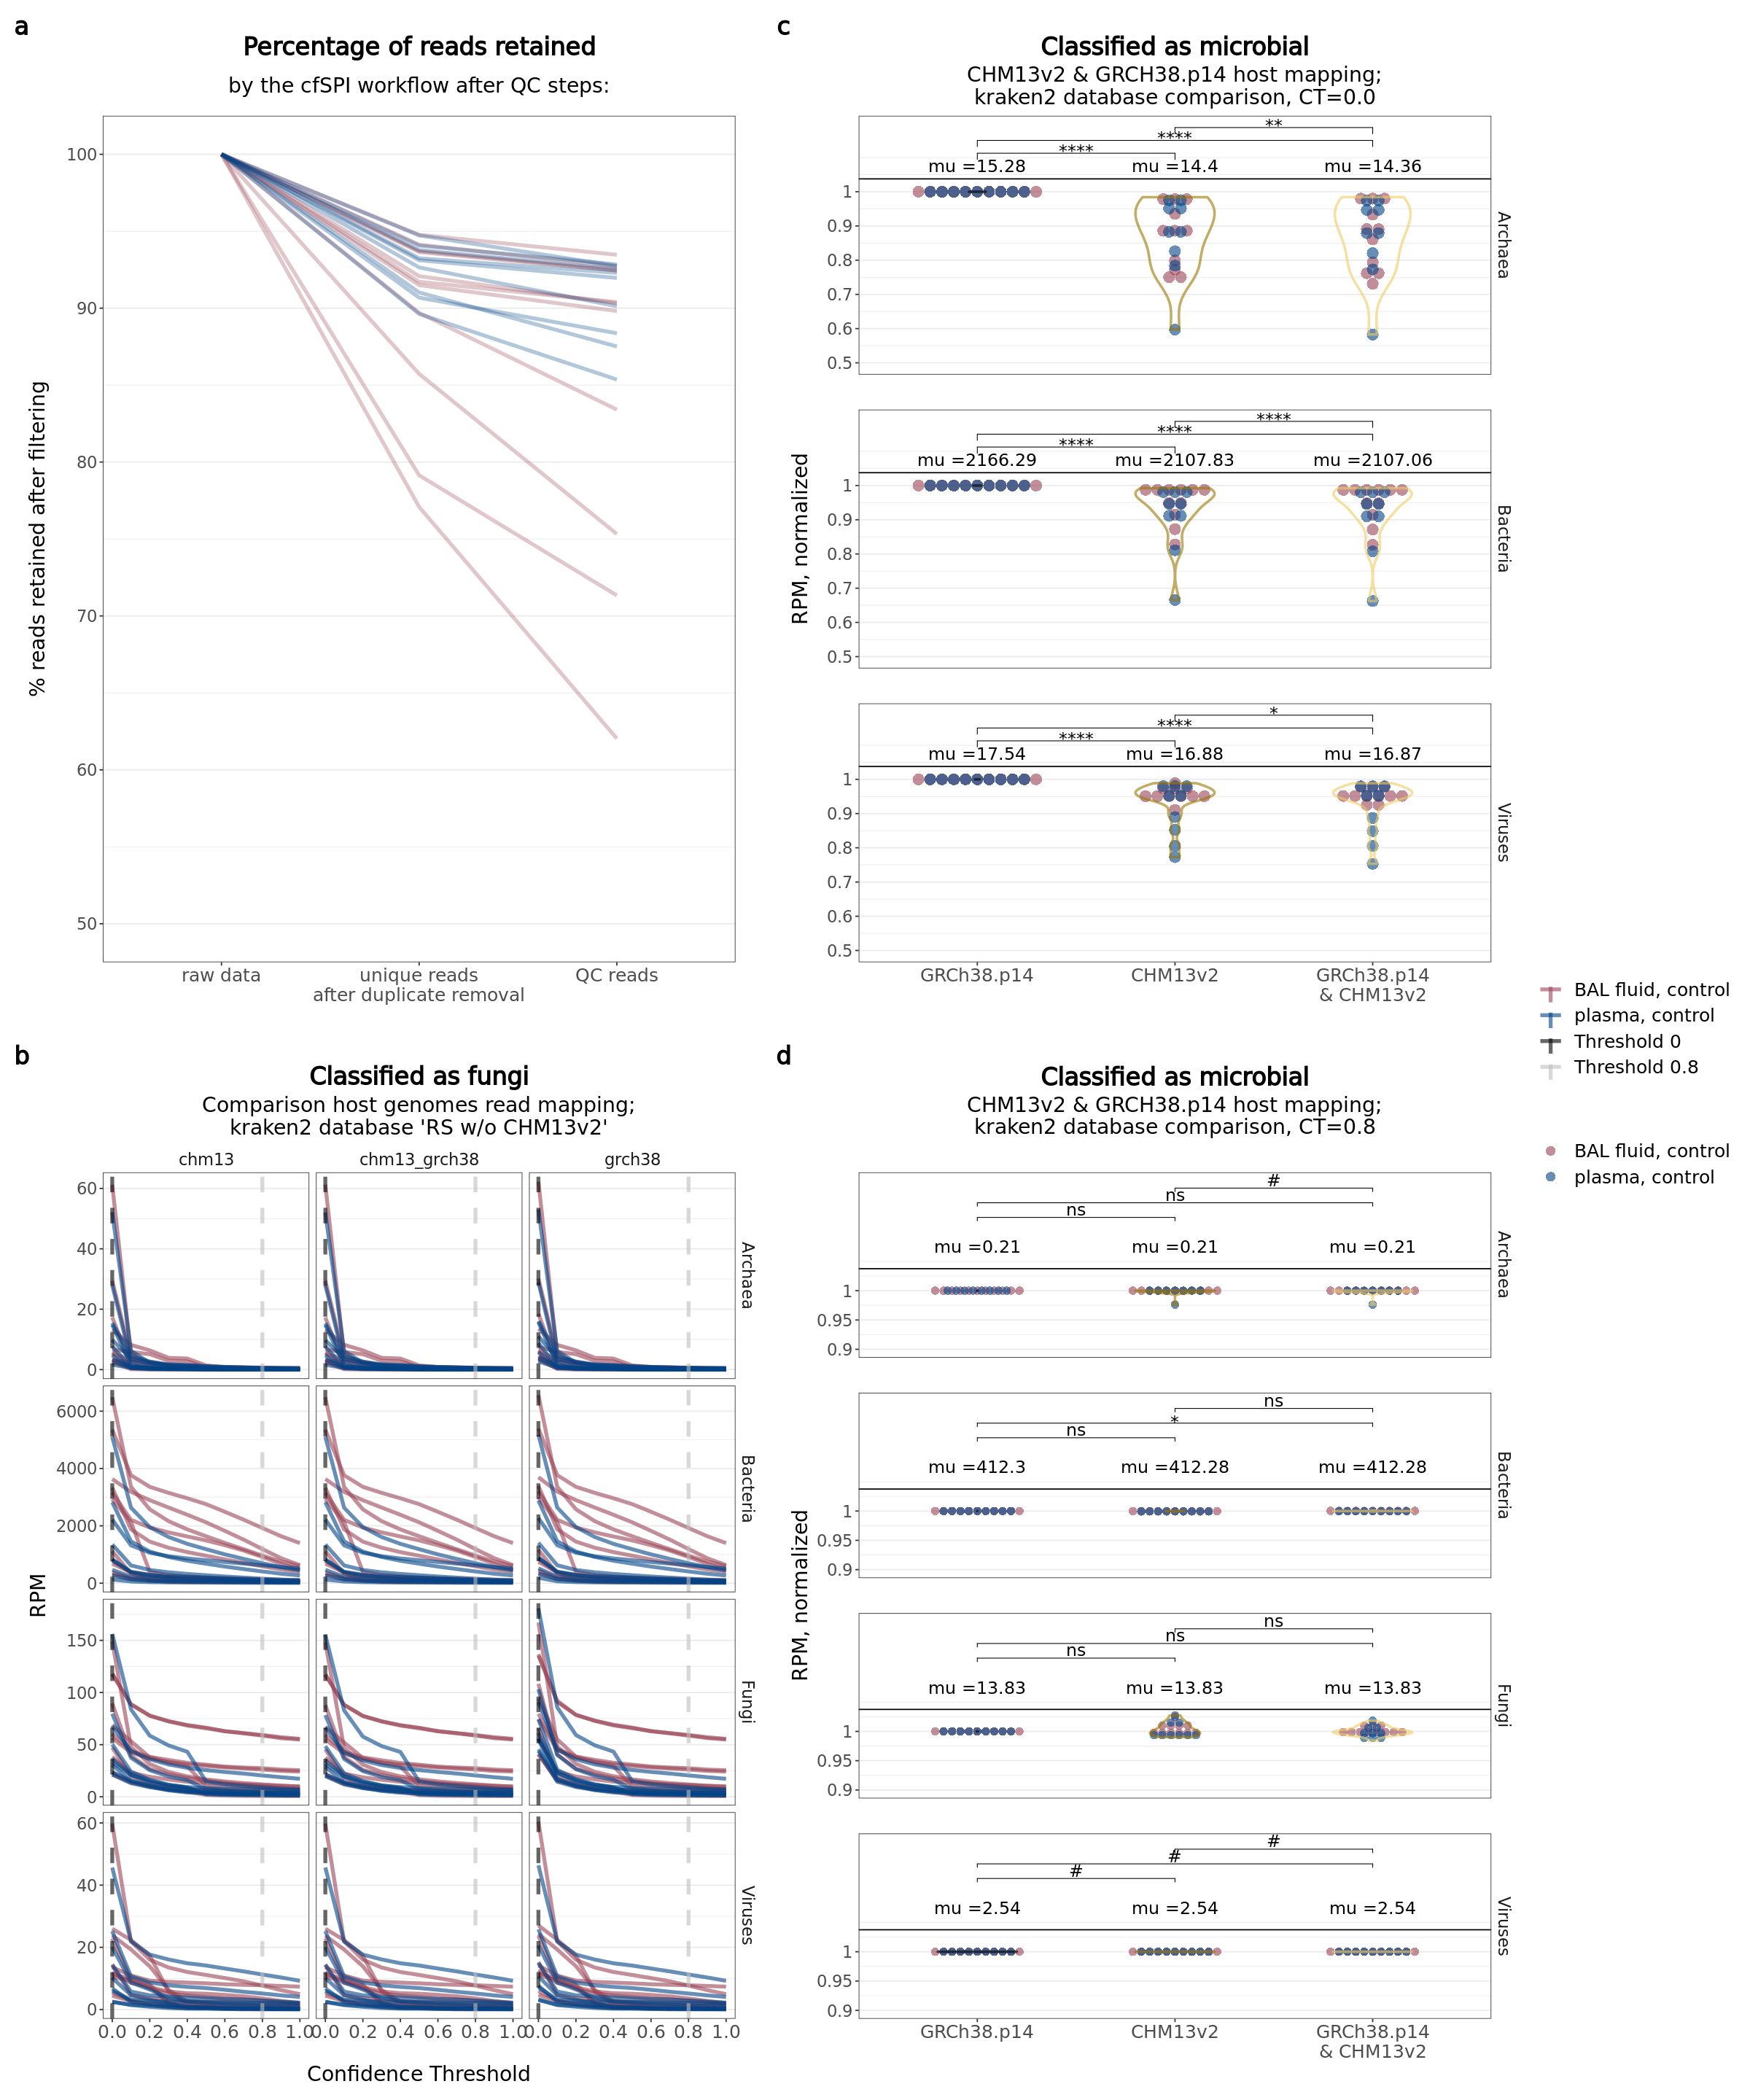

In [15]:
options(repr.plot.width=20, repr.plot.height=24)
layout <- "AC
           BD"
SuplFig1 <- 
    (cfSPI_steps + ggtitle("Percentage of reads retained", subtitle = "by the cfSPI workflow after QC steps:")) +
    (all_thresholds_suppl + ggtitle("Classified as fungi", 
            subtitle = "Comparison host genomes read mapping;\nkraken2 database 'RS w/o CHM13v2'")) +
    (micr_k2_standard + ggtitle("Classified as microbial", subtitle = "CHM13v2 & GRCH38.p14 host mapping;\nkraken2 database comparison, CT=0.0")) + 
    (micr_k2_standard_0.8 + ggtitle("Classified as microbial", subtitle = "CHM13v2 & GRCH38.p14 host mapping;\nkraken2 database comparison, CT=0.8")) + 
        plot_layout(design = layout, ncol = 2, guides="collect") &
        plot_annotation(tag_levels = 'a') &
        theme(legend.position='right', legend.justification='right', legend.direction = 'vertical',
            axis.text.x = element_text(size = 15), 
            legend.key.size = unit(0.75, 'cm'), legend.key.height = unit(0.75, 'cm'), legend.key.width = unit(0.75, 'cm'), 
            text = element_text(size = 17), 
            legend.title = element_text(size = 18), legend.text = element_text(size = 15, colour = "black"),
            plot.title = element_text(size = 20, hjust = 0.5, face = "bold"), 
            plot.subtitle = element_text(size = 17, hjust = 0.5), 
            plot.tag = element_text(face = 'bold', size = 20), 
            strip.background = element_blank(),
            panel.grid.major.x = element_blank(),
            panel.grid.minor.x = element_blank())

SuplFig1

ggsave("../../output/suppl_figures/SuplFig1_R.png", 
       SuplFig1, width = 20, height = 24)
ggsave("../../output/suppl_figures/SuplFig1_R.pdf", 
       SuplFig1, width = 20, height = 24)